In [1]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[16:03:00] WARNING: not removing hydrogen atom without neighbors
[16:03:00] WARNING: not removing hydrogen atom without neighbors
[16:03:00] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [2]:
from typing import Literal
lib: Literal["NIST", "MSDIAL", "NIST/MSDIAL", "MSnLib"] = "MSnLib" #"MSnLib"
print(f"Preparing {lib} library")

debug_mode = False # Default: False
if debug_mode:
    print("+++ This is a test run (debug mode) with a small subset of data points. Results are not representative. +++")

Preparing MSnLib library


In [3]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    if ("NIST" in lib or "MSDIAL" in lib):
        data_path: str = f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv"
    elif lib == "MSnLib":
        data_path: str = f"{home}/data/metabolites/preprocessed/datasplits_msnlib_v6_July25.csv"
    else:
        raise NameError(f"Unknown library selected {lib=}.")
    L = LibraryLoader()
    df = L.load_from_csv(data_path)
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [4]:
# import polars as pl
# pdf = pl.from_pandas(df)

In [ ]:
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.CovariateFeatureEncoder import CovariateFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0


if debug_mode:
    df = df.iloc[:10000,:]
    #df = df.iloc[5000:20000,:]

overwrite_setup_features = None
if lib == "MSnLib":
    overwrite_setup_features = {
        "instrument": ["HCD"],
        "precursor_mode": ["[M+H]+", "[M-H]-", "[M]+", "[M]-"]
    
    }


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
covariate_encoder = CovariateFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument", "element_composition"], sets_overwrite=overwrite_setup_features)
rt_encoder = CovariateFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument", "element_composition"], sets_overwrite=overwrite_setup_features)

covariate_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
covariate_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)
_ = df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

In [ ]:
from fiora.MOL.MetaboliteIndex import MetaboliteIndex

mindex: MetaboliteIndex = MetaboliteIndex()
mindex.index_metabolites(df["Metabolite"])

In [ ]:
mindex.create_fragmentation_trees()
list_of_mismatched_ids = mindex.add_fragmentation_trees_to_metabolite_list(df["Metabolite"], graph_mismatch_policy="recompute")
print(f"Total number of recomputed trees: {len(list_of_mismatched_ids)}")

Total number of recomputed trees: 9


In [ ]:
%%capture
#df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

In [ ]:
df["num_peak_matches"] = df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"])
print(sum(df["num_peak_matches"] < 1))
df = df[df["num_peak_matches"] >= 2]

0


##### Load Casmi data

In [ ]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)

df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)

## Model Training and Testing

In [ ]:
import torch_geometric as geom

if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
    dev = "cuda:0"
else: 
    dev = "cpu" 
 
print(f"Running on device: {dev}")

Running on device: cuda:0


##### Load Data

In [ ]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

df_test = df[df["dataset"] == "test"]
df_train = df[df["dataset"].isin(["training", "validation"])]

dataset
test           276
training      2553
validation     306
Name: group_id, dtype: int64


In [ ]:
geo_data = df_train["Metabolite"].apply(lambda x: x.as_geometric_data().to(dev)).values
print(f"Prepared training/validation with {len(geo_data)} data points")

Prepared training/validation with 9086 data points


##### Prepare Model

In [ ]:
model_params = {
    'param_tag': 'default',

    #GNN parameters
    'gnn_type': 'RGCNConv',
    'depth': 12, # 5 or 6
    'hidden_dimension': 300, # 300
    'residual_connections': False,
    'layer_stacking': True, # Avoid residual connections and layer stacking at the same time
    'embedding_aggregation': 'concat',
    'embedding_dimension': 300, # 300,
    
    # Dense layers
    'dense_layers': 2, # 2 # Number of "hidden" dense layers, an additional output layer is always added
    'dense_dim': 1000, # Set to None (then dense dim defaults to GNN output dimension (very large if layer stacking is active))

    # Dropout
    'input_dropout': 0.2, # 0.2,
    'latent_dropout': 0.2, # 0.1,
    
    # Dimensions
    'node_feature_layout': node_encoder.feature_numbers,
    'edge_feature_layout': bond_encoder.feature_numbers,    
    'static_feature_dimension': geo_data[0]["static_edge_features"].shape[1],
    'static_rt_feature_dimension': geo_data[0]["static_rt_features"].shape[1],
    'output_dimension': len(DEFAULT_MODES) * 2, # per edge 
    
    # Keep track of how features are encoded
    'atom_features': node_encoder.feature_list,
    'atom_features': bond_encoder.feature_list,
    'setup_features': covariate_encoder.feature_list,
    'setup_features_categorical_set': covariate_encoder.categorical_sets,
    'rt_features': rt_encoder.feature_list,
    
    # Set default flags (May be overwritten below)
    'prepare_additional_layers': False,
    'rt_supported': False,
    'ccs_supported': False,
    'version': "x.x.x"
    
}
training_params = {
    'epochs': 200 if not debug_mode else 10, 
    'batch_size': 32, # 256, # 256
    #'train_val_split': 0.90,
    'learning_rate': 2e-4, # 4e-4, 
    'weight_decay': 1e-8, #1e-4,
    'with_RT': False, # Turn off RT/CCS for initial trainings round
    'with_CCS': False
}

In [ ]:
from fiora.GNN.FioraModel import FioraModel
model_snapshot = FioraModel(model_params)
# Print num of parameters of model
num_params = sum(p.numel() for p in model_snapshot.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")

Number of trainable parameters: 19,465,161


In [ ]:
# Print number of parameters for each submodule GNN_module, precursor_module, edge_module
# for name, param in model_snapshot.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.numel():,}")

del model_snapshot

##### Begin Training

In [ ]:
import numpy as np

# Subsample training datas
def subsample_keys(train_keys, val_keys, down_to_fraction: float):
    train_sample = np.random.choice(train_keys, size=int(len(train_keys) * down_to_fraction), replace=False)
    val_sample = np.random.choice(val_keys, size=int(len(val_keys) * down_to_fraction), replace=False)
    return train_sample, val_sample


In [ ]:
from fiora.GNN.SpectralTrainer import SpectralTrainer
from fiora.GNN.FioraModel import FioraModel
from fiora.GNN.Losses import WeightedMSELoss, WeightedMSEMetric, WeightedMAELoss, WeightedMAEMetric
from fiora.MS.SimulationFramework import SimulationFramework

fiora = SimulationFramework(None, dev=dev)
# fiora = SimulationFramework(None, dev=dev, with_RT=training_params["with_RT"], with_CCS=training_params["with_CCS"])
np.seterr(invalid='ignore')
tag = "training"
val_interval = 1
metric_dict= {"mse": WeightedMSEMetric} #WeightedMSEMetric
loss_fn = WeightedMSELoss() # WeightedMSELoss()
all_together = False
down_sample = False

if all_together:
    val_interval = 200
    metric_dict=None
    loss_fn = torch.nn.MSELoss()    

def train_new_model(continue_with_model=None):
    if continue_with_model:
        model = continue_with_model.to(dev)
    else:
        model = FioraModel(model_params).to(dev)
        
    y_label = 'compiled_probsSQRT' # y_label = 'compiled_probsALL'
    optimizer = torch.optim.Adam(model.parameters(), lr=training_params["learning_rate"], weight_decay=training_params["weight_decay"])
    if all_together:
        trainer = SpectralTrainer(geo_data, y_tag=y_label, problem_type="regression", only_training=True, metric_dict=metric_dict, split_by_group=True, seed=seed, device=dev)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    else:
        train_keys, val_keys = df[df["dataset"] == "training"]["group_id"].unique(), df[df["dataset"] == "validation"]["group_id"].unique()
        if down_sample:
            train_fraction = 0.10
            train_keys, val_keys = subsample_keys(train_keys, val_keys, train_fraction) # Downsample training data for test
            print(f"Sample down to {train_fraction * 100}% with {len(train_keys)} training and {len(val_keys)} validation compounds ")
        trainer = SpectralTrainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=metric_dict, split_by_group=True, seed=seed, device=dev)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 8, factor=0.5, mode = 'min')

    
    checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=training_params['batch_size'], epochs=training_params["epochs"], val_every_n_epochs=1, with_CCS=training_params["with_CCS"], with_RT=training_params["with_RT"], use_validation_mask=False, tag=tag) #, mask_name="compiled_validation_maskALL")   
    print(checkpoints)
    return model, checkpoints, trainer

def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF, score="spectral_sqrt_cosine", return_df=False):
    dft = simulate_all(model, DF)
    
    if return_df:
        return dft
    return dft[score].values

In [ ]:
def grid_search(param_grid, base_model_params, base_training_params, store_models: bool = False):
    results = []

    for i, param_override in enumerate(param_grid):
        print(f"Running configuration {i + 1}/{len(param_grid)}...")
        
        # Update base parameters with overrides
        model_params = base_model_params.copy()
        training_params = base_training_params.copy()
        
        model_params.update(param_override.get("model_params", {}))
        training_params.update(param_override.get("training_params", {}))
        
        # Train the model with the updated parameters
        try:
            model, checkpoints, trainer = train_new_model()
            results.append({
                "config": param_override,
                "model": model if store_models else None,
                "checkpoints": checkpoints,
                "trainer": trainer
            })

            if not store_models:
                del model
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"Error in configuration {i + 1}: {e}")
            results.append({
                "config": param_override,
                "error": str(e)
            })

    return results

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
GRID_SEARCH = False
if GRID_SEARCH:
    param_grid = [
        # Depth 12 test rigorous regularization
        #{"model_params": {"depth": 12}, "training_params": {}},
        {"model_params": {"depth": 12, 'gnn_type': 'TransformerConv', "hidden_dimension": 600, "embedding_dimension": 600}, "training_params": {}},
        #{"model_params": {"depth": 12, 'gnn_type': 'TransformerConv', "hidden_dimension": 600, "embedding_dimension": 600}, "training_params": {"learning_rate": 1e-4}},

    ]

    grid_results = grid_search(param_grid, model_params, training_params, store_models=True)

    # Analyze results
    for result in grid_results:
        print(result["config"])
        if "error" in result:
            print(f"Error: {result['error']}")
        else:
            print(f"Checkpoints: {result['checkpoints']}")

Running configuration 1/1...
Using pre-set train/validation keys
	Validation RMSE: 0.00852
	 >> Set new checkpoint to epoch 1
	Validation RMSE: 0.00818
	 >> Set new checkpoint to epoch 2
	Validation RMSE: 0.00797
	 >> Set new checkpoint to epoch 3


KeyboardInterrupt: 

In [ ]:
if 'model' in locals():
    del model
    torch.cuda.empty_cache()

if not GRID_SEARCH:
    print(f"Training model")
    model, checkpoints, trainer = train_new_model() # continue_with_model=model)

In [ ]:
import copy

print(checkpoints) 
model_at_last_epoch = copy.deepcopy(model)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x779df6fa79a0>
Traceback (most recent call last):
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/selectors.py", line 416,

NameError: name 'checkpoints' is not defined

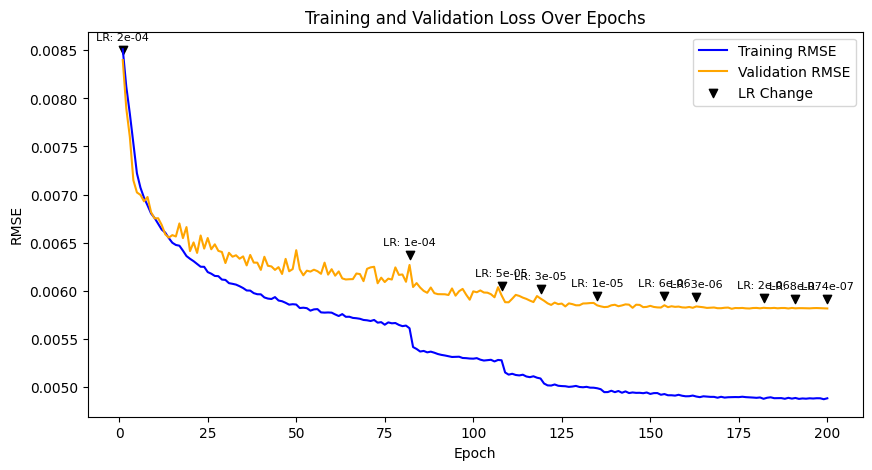

Minimum Training RMSE: 0.00487 (Epoch 199)
Minimum Validation RMSE: 0.00581 (Epoch 173)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert numpy arrays to scalars if they are single-element arrays
trainer.history["train_error"] = [
    error.item() if isinstance(error, np.ndarray) and error.size == 1 else error
    for error in trainer.history["train_error"]
]
trainer.history["val_error"] = [
    error.item() if isinstance(error, np.ndarray) and error.size == 1 else error
    for error in trainer.history["val_error"]
]
trainer.history["lr"] = [
    lr.item() if isinstance(lr, np.ndarray) and lr.size == 1 else lr
    for lr in trainer.history["lr"]
]

# Create a DataFrame from the tracker dictionary
tracker_df = pd.DataFrame({
    "epoch": trainer.history["epoch"],
    "train_rmse": trainer.history["sqrt_train_error"],
    "val_rmse": trainer.history["sqrt_val_error"],
    "lr": trainer.history["lr"]
})

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=tracker_df, x="epoch", y="train_rmse", label="Training RMSE", color="blue")
sns.lineplot(data=tracker_df, x="epoch", y="val_rmse", label="Validation RMSE", color="orange")

# Highlight the epochs where the learning rate changes
previous_lr = None
for _, row in tracker_df.iterrows():
    current_lr = row["lr"]
    if current_lr != previous_lr:
        epoch = row["epoch"]
        val_loss_at_epoch = row["val_rmse"]
        plt.scatter(epoch, val_loss_at_epoch + 0.0001, color="black", marker="v", label="LR Change" if previous_lr is None else "")
        plt.text(epoch, val_loss_at_epoch + 0.0002, f"LR: {current_lr:1.0e}", color="black", ha="center", fontsize=8)
        previous_lr = current_lr

plt.xlabel("Epoch")
plt.ylabel("RMSE")
#plt.ylim(0, tracker_df["val_rmse"].max() + 0.004)
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()
min_train_error = min(trainer.history["sqrt_train_error"])
min_val_error = min(trainer.history["sqrt_val_error"])
epoch_min_train_error = trainer.history["epoch"][np.argmin(trainer.history["sqrt_train_error"])]
epoch_min_val_error = trainer.history["epoch"][np.argmin(trainer.history["sqrt_val_error"])]
print(f"Minimum Training RMSE: {min_train_error:.5f} (Epoch {epoch_min_train_error})")
print(f"Minimum Validation RMSE: {min_val_error:.5f} (Epoch {epoch_min_val_error})")

In [ ]:
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

#
# CASMI 22
#

df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

In [ ]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum

def test_cas16(model, df_cas=df_cas, score="merged_sqrt_cosine", return_df=False):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3

    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_cosine_wo_prec"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine_wo_prec"] = df_cas["merged_sqrt_cosine_wo_prec"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    if hasattr(model, "rt_module"):
        df_cas["RT_pred"] = df_cas["RT_pred_35"]
        df_cas["RT_dif"] = df_cas["RT_dif_35"]
    if hasattr(model, "ccs_module"):
        df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"
    
    if return_df:
        return df_cas
    
    return df_cas[score].values

In [ ]:
model = FioraModel.load(checkpoints["file"]).to(dev)
score = "spectral_sqrt_cosine"

val_results = test_model(model, df_train[df_train["dataset"]== "validation"], score=score)
test_results = test_model(model, df_test, score=score)
casmi16_results = test_cas16(model, score=score)
casmi16_p = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M+H]+"], score=score)
casmi16_n = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M-H]-"], score=score)
casmi22_results = test_model(model, df_cas22, score=score)
casmi22_p = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M+H]+"], score=score)
casmi22_n = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M-H]-"], score=score)
    
results = [{"model": model, "validation": val_results, "test": test_results, "casmi16": casmi16_results, "casmi22": casmi22_results, "casmi16+": casmi16_p, "casmi16-": casmi16_n, "casmi22+": casmi22_p, "casmi22-": casmi22_n}]

/tmp/ipykernel_420075/2671199409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
/tmp/ipykernel_420075/2671199409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
/tmp/ipykernel_420075/2671199409.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
score = "spectral_sqrt_cosine_wo_prec"
val_results = test_model(model, df_train[df_train["dataset"]== "validation"], score=score)
test_results = test_model(model, df_test, score=score)
casmi16_results = test_cas16(model, score=score)
casmi16_p = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M+H]+"], score=score)
casmi16_n = test_cas16(model, df_cas[df_cas["Precursor_type"] == "[M-H]-"], score=score)
casmi22_results = test_model(model, df_cas22, score=score)
casmi22_p = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M+H]+"], score=score)
casmi22_n = test_model(model, df_cas22[df_cas22["Precursor_type"] == "[M-H]-"], score=score)
    
results_wop = [{"model": model, "validation": val_results, "test": test_results, "casmi16": casmi16_results, "casmi22": casmi22_results, "casmi16+": casmi16_p, "casmi16-": casmi16_n, "casmi22+": casmi22_p, "casmi22-": casmi22_n}]

/tmp/ipykernel_420075/2671199409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
/tmp/ipykernel_420075/2671199409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
/tmp/ipykernel_420075/2671199409.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
LOG = pd.DataFrame(results)
eval_columns = LOG.columns[1:].fillna(0.0)
LOG[eval_columns] = LOG[eval_columns].apply(lambda x: x.apply(np.median))

LOG

,model,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,FioraModel(\n (node_embedding): FeatureEmbedd...,0.757925,0.72839,0.685405,0.26277,0.640069,0.752567,0.236746,0.288136


In [ ]:
LOG = pd.DataFrame(results_wop).fillna(0.0)
eval_columns = LOG.columns[1:]
LOG[eval_columns] = LOG[eval_columns].apply(lambda x: x.apply(np.nan_to_num).apply(np.median))

LOG

,model,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,FioraModel(\n (node_embedding): FeatureEmbedd...,0.719987,0.683804,0.406003,0.230323,0.363107,0.475598,0.213041,0.287407


In [ ]:
# LOG = pd.DataFrame(results)
# eval_columns = LOG.columns[3:]

# home_path = f"{home}/data/metabolites/benchmarking/"
# NAME = model_params["gnn_type"] + "_depth.csv"
# for col in eval_columns:
#     LOG[col] = LOG[col].apply(lambda x: str(list(x)))
# LOG.to_csv(home_path + NAME, index=False, sep="\t")

In [ ]:
# LOGIC = pd.read_csv(home_path + NAME, sep="\t")
# for col in eval_columns:
#     LOGIC[col] = LOGIC[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))

# LOGIC[eval_columns] = LOGIC[eval_columns].apply(lambda x: x.apply(np.median))
# LOGIC

In [ ]:
raise KeyboardInterrupt("Halt! Make sure you wish to save/overwrite model files")

KeyboardInterrupt: Halt! Make sure you wish to save/overwrite model files

In [ ]:
depth = model_params["depth"]
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.1.1_OS_depth{depth}_June25.pt"
model.save(MODEL_PATH)
print(f"Saved to {MODEL_PATH}")

Saved to /home/ynowatzk/data/metabolites/pretrained_models/v0.1.1_OS_depth12_June25.pt


In [ ]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [ ]:
from fiora.GNN.GNNModules import GNNCompiler

In [ ]:
df_test["Metabolite"].iloc[0].as_geometric_data()

Data(x=[32, 3], edge_index=[2, 72], edge_attr=[72, 2], y=[72, 1], edge_type=[72], static_graph_features=[1, 8], static_edge_features=[72, 8], static_rt_features=[1, 7], compiled_probs=[74], compiled_probs2=[146], compiled_probs6=[434], compiled_probsALL=[722], compiled_probsSQRT=[722], compiled_probsDEPRE=[722], compiled_probs_wo_prec=[722], compiled_counts=[74], edge_break_count=[72, 1], retention_time=[1, 1], retention_mask=[1, 1], ccs=[1, 1], ccs_mask=[1, 1], validation_mask=[72, 1], compiled_validation_mask=[74], compiled_validation_mask2=[146], compiled_validation_mask6=[434], compiled_validation_maskALL=[722], group_id=11, weight=[1, 1], weight_tensor=[722], is_node_aromatic=[32, 1], is_edge_aromatic=[72, 1])

In [ ]:
dev="cuda:0"
mymy = GNNCompiler.load(MODEL_PATH) # f"{home}/data/metabolites/pretrained_models/v0.0.1_merged_2.pt"
#mymy.load_state_dict(torch.load(f"{home}/data/metabolites/pretrained_models/test.pt"))
mymy.eval()
mymy = mymy.to(dev)


In [ ]:
np.median(test_model(mymy, df_test))

0.6777992132153692

In [ ]:
np.median(test_model(mymy, df_cas22))

0.2357750642225984

In [ ]:
import json
with open(MODEL_PATH.replace(".pt", "_params.json"), 'r') as fp:
    p = json.load(fp)
hh = GNNCompiler(p)
hh.load_state_dict(torch.load(MODEL_PATH.replace(".pt", "_state.pt")))
hh.eval()
hh = hh.to(dev)

In [ ]:
np.median(test_model(hh, df_cas22))

0.2357750642225984

In [ ]:
raise KeyboardInterrupt("TODO")

KeyboardInterrupt: TODO

In [ ]:
## prepare output for for CFM-ID
import os
save_df = False
cfm_directory = f"{home}/data/metabolites/cfm-id/"
name = "test_split_negative_solutions_cfm.txt"
df_cfm = df_test[["group_id", "SMILES", "Precursor_type"]]
df_n = df_cfm[df_cfm["Precursor_type"] == "[M-H]-"].drop_duplicates(subset='group_id', keep='first')
df_p = df_cfm[df_cfm["Precursor_type"] == "[M+H]+"].drop_duplicates(subset='group_id', keep='first')

print(df_n.head())

if save_df:
    file = os.path.join(cfm_directory, name)
    df_n[["group_id", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")
    
    name = name.replace("negative", "positive")
    file = os.path.join(cfm_directory, name)
    df_p[["group_id", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")

       group_id                                             SMILES  \
91358       695  CCCCCCCCCCCCCCCC(=O)OC[C@@H](O)COP(=O)([O-])OC...   
91888      1028  CN1c2c([nH]c(N)nc2=O)NCC1CNc1ccc(C(=O)N[C@@H](...   
91898      1030  CC(C)C[C@@H](N)[C@H](O)C(=O)N[C@H](C(=O)N[C@H]...   
92031      8617        CCCCC[C@H](O)/C=C/C=C\C/C=C\C/C=C\CCCC(=O)O   
92174      1061                    CC(=O)N[C@@H](CCCNC(=N)N)C(=O)O   

      Precursor_type  
91358         [M-H]-  
91888         [M-H]-  
91898         [M-H]-  
92031         [M-H]-  
92174         [M-H]-  
